In [1]:
# Add mooncake to sys

import sys

mooncake_path = '/Users/ramonamezquita/Projects/mooncake'
sys.path.append(mooncake_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [53]:
# Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from mooncake.preprocessing import GroupColumnTransformer
from mooncake.preprocessing import TimeIndex
from mooncake.preprocessing import ColumnTransformer
from mooncake.preprocessing import CyclicalDates
from mooncake.helper import column_selector

In [4]:
def select_top_n_groups(X, n, group_ids, wrt, aggfunc=sum):
    top_group_ids =  X.groupby(
        group_ids).agg({wrt: aggfunc}).nlargest(n, wrt).index.tolist()
    
    return X.set_index(group_ids).loc[top_group_ids].reset_index()

In [13]:
# Data and description

X = pd.read_csv('sales_forecasting_dataset.csv')

# Description
date = 'Date'
group_ids = ['Store', 'Dept']
target = 'Weekly_Sales'

# Sort
X = X.sort_values(group_ids + [date])

# Send group ids to object dtype
for g in group_ids:
    X[g] = X[g].astype(str)
    
# To datetime
X[date] = pd.to_datetime(X[date], format="%d/%m/%Y")

In [14]:
# Reduce data to top n products

n_groups_to_use = 20
X = select_top_n_groups(X, n_groups_to_use, group_ids, target)

In [15]:
# Add time index

X['time_idx'] = X[date].copy()
time_index_transformer = GroupColumnTransformer(
    transformers=[('time_idx', TimeIndex(), 'time_idx')],
    group_ids=group_ids
)
X = time_index_transformer.fit_transform(X)

In [17]:
# Split

from mooncake.model_selection import train_test_split

test_start = '2012-10-01'
test_end = '2012-12-10'
freq = 'W'
prediction_length = len(pd.date_range(test_start, test_end, freq=freq))
max_encoder_length = 2 * prediction_length
X_train, X_test = train_test_split(
    X, 
    test_start, 
    test_end, 
    date, 
    freq=freq, 
    sequence_length=max_encoder_length
)

In [18]:
# Group transformer
num_selector = column_selector(dtype_include=(int, float), pattern_exclude='time_idx')
group_transformers = [
    ('num', MinMaxScaler(), num_selector),
]
group_transformer = GroupColumnTransformer(group_transformers, group_ids=group_ids)

In [19]:
# ColumnTransformer

column_transformers = [
    ('cyclical_dates', CyclicalDates(), ['Date']),
    ('cat', OneHotEncoder(dtype=int, drop='if_binary'), ['IsHoliday'])
]
column_transformer = ColumnTransformer(column_transformers)

In [20]:
pipe = Pipeline([
    ('group', group_transformer),
    ('non_group', column_transformer)
])

In [31]:
X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

# Train

## seq2seq

In [32]:
from mooncake.nn import SeqToSeq
from mooncake.helper import common_callbacks
from torch.optim.lr_scheduler import OneCycleLR

In [48]:
# Fit

column_segmentation = {
    'static_categoricals': group_ids,
    'time_varying_unknown_reals': ['Weekly_Sales'],
    'time_varying_known_reals': ['x0_True', 'day_sine', 'day_cos', 'month_sine', 'month_cos']
}
lr_scheduler = {
        'policy': OneCycleLR,
        'step_every': 'batch',
        'max_lr': 1e-3,
        'steps_per_epoch': 'iterations',
        'epochs': 'max_epochs'
    }
callbacks = common_callbacks(
    lr_scheduler, 
    gradient_clipping=True,
    early_stopping=True, 
    patience=20
)

estimator = SeqToSeq(
    group_ids=group_ids,
    time_idx='time_idx',
    target=target,
    max_prediction_length=prediction_length,
    max_encoder_length=prediction_length,
    cv_split=X_test_transformed,
    batch_size=128,
    max_epochs=100,
    callbacks=callbacks,
    hidden_size=16,
    **column_segmentation
)

In [49]:
estimator.fit(X=X_train_transformed)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4285        0.4733  0.3378
      2        0.4256        0.4689  0.3342
      3        0.4238        0.4636  0.3337
      4        0.4190        0.4569  0.3348
      5        0.4104        0.4484  0.3317
      6        0.4015        0.4377  0.3320
      7        0.3901        0.4242  0.3311
      8        0.3779        0.4073  0.3374
      9        0.3601        0.3856  0.3415
     10        0.3383        0.3571  0.3392
     11        0.3090        0.3177  0.3433
     12        0.2675        0.2630  0.3383
     13        0.2219        0.2266  0.3657
     14        0.2074        0.2177  0.3409
     15        0.2020        0.2129  0.3589
     16        0.1992        0.2054  0.3576
     17        0.1925        0.1938  0.3430
     18        0.1838        0.1812  0.3646
     19        0.1738        0.1664  0.3429
     20        0.1676        0.1583  0.3555
     21        0.1677        0.1

SeqToSeq(batch_size=128,
         callbacks=[('lr_scheduler',
                     <skorch.callbacks.lr_scheduler.LRScheduler object at 0x16d170400>),
                    ('early_stopping',
                     <skorch.callbacks.training.EarlyStopping object at 0x16d1703d0>),
                    ('gradient_clipping',
                     <skorch.callbacks.regularization.GradientNormClipping object at 0x17849f580>)],
         criterion=<class 'pytorch_forecasting.metrics.RMSE'>,
         cv_spl...
[460 rows x 9 columns],
         group_ids=['Store', 'Dept'], max_encoder_length=10, max_epochs=100,
         max_prediction_length=10, optimizer=<class 'torch.optim.adam.Adam'>,
         static_categoricals=['Store', 'Dept'], target='Weekly_Sales',
         time_idx='time_idx',
         time_varying_known_reals=['x0_True', 'day_sine', 'day_cos',
                                   'month_sine', 'month_cos'],
         time_varying_unknown_reals=['Weekly_Sales'])

In [50]:
yhat_train = estimator.predict(
    X_train_transformed, 
    raw=False, 
    inverse_transformer=pipe
)
yhat_test = estimator.predict(
    X_test_transformed, 
    raw=False, 
    inverse_transformer=pipe
)

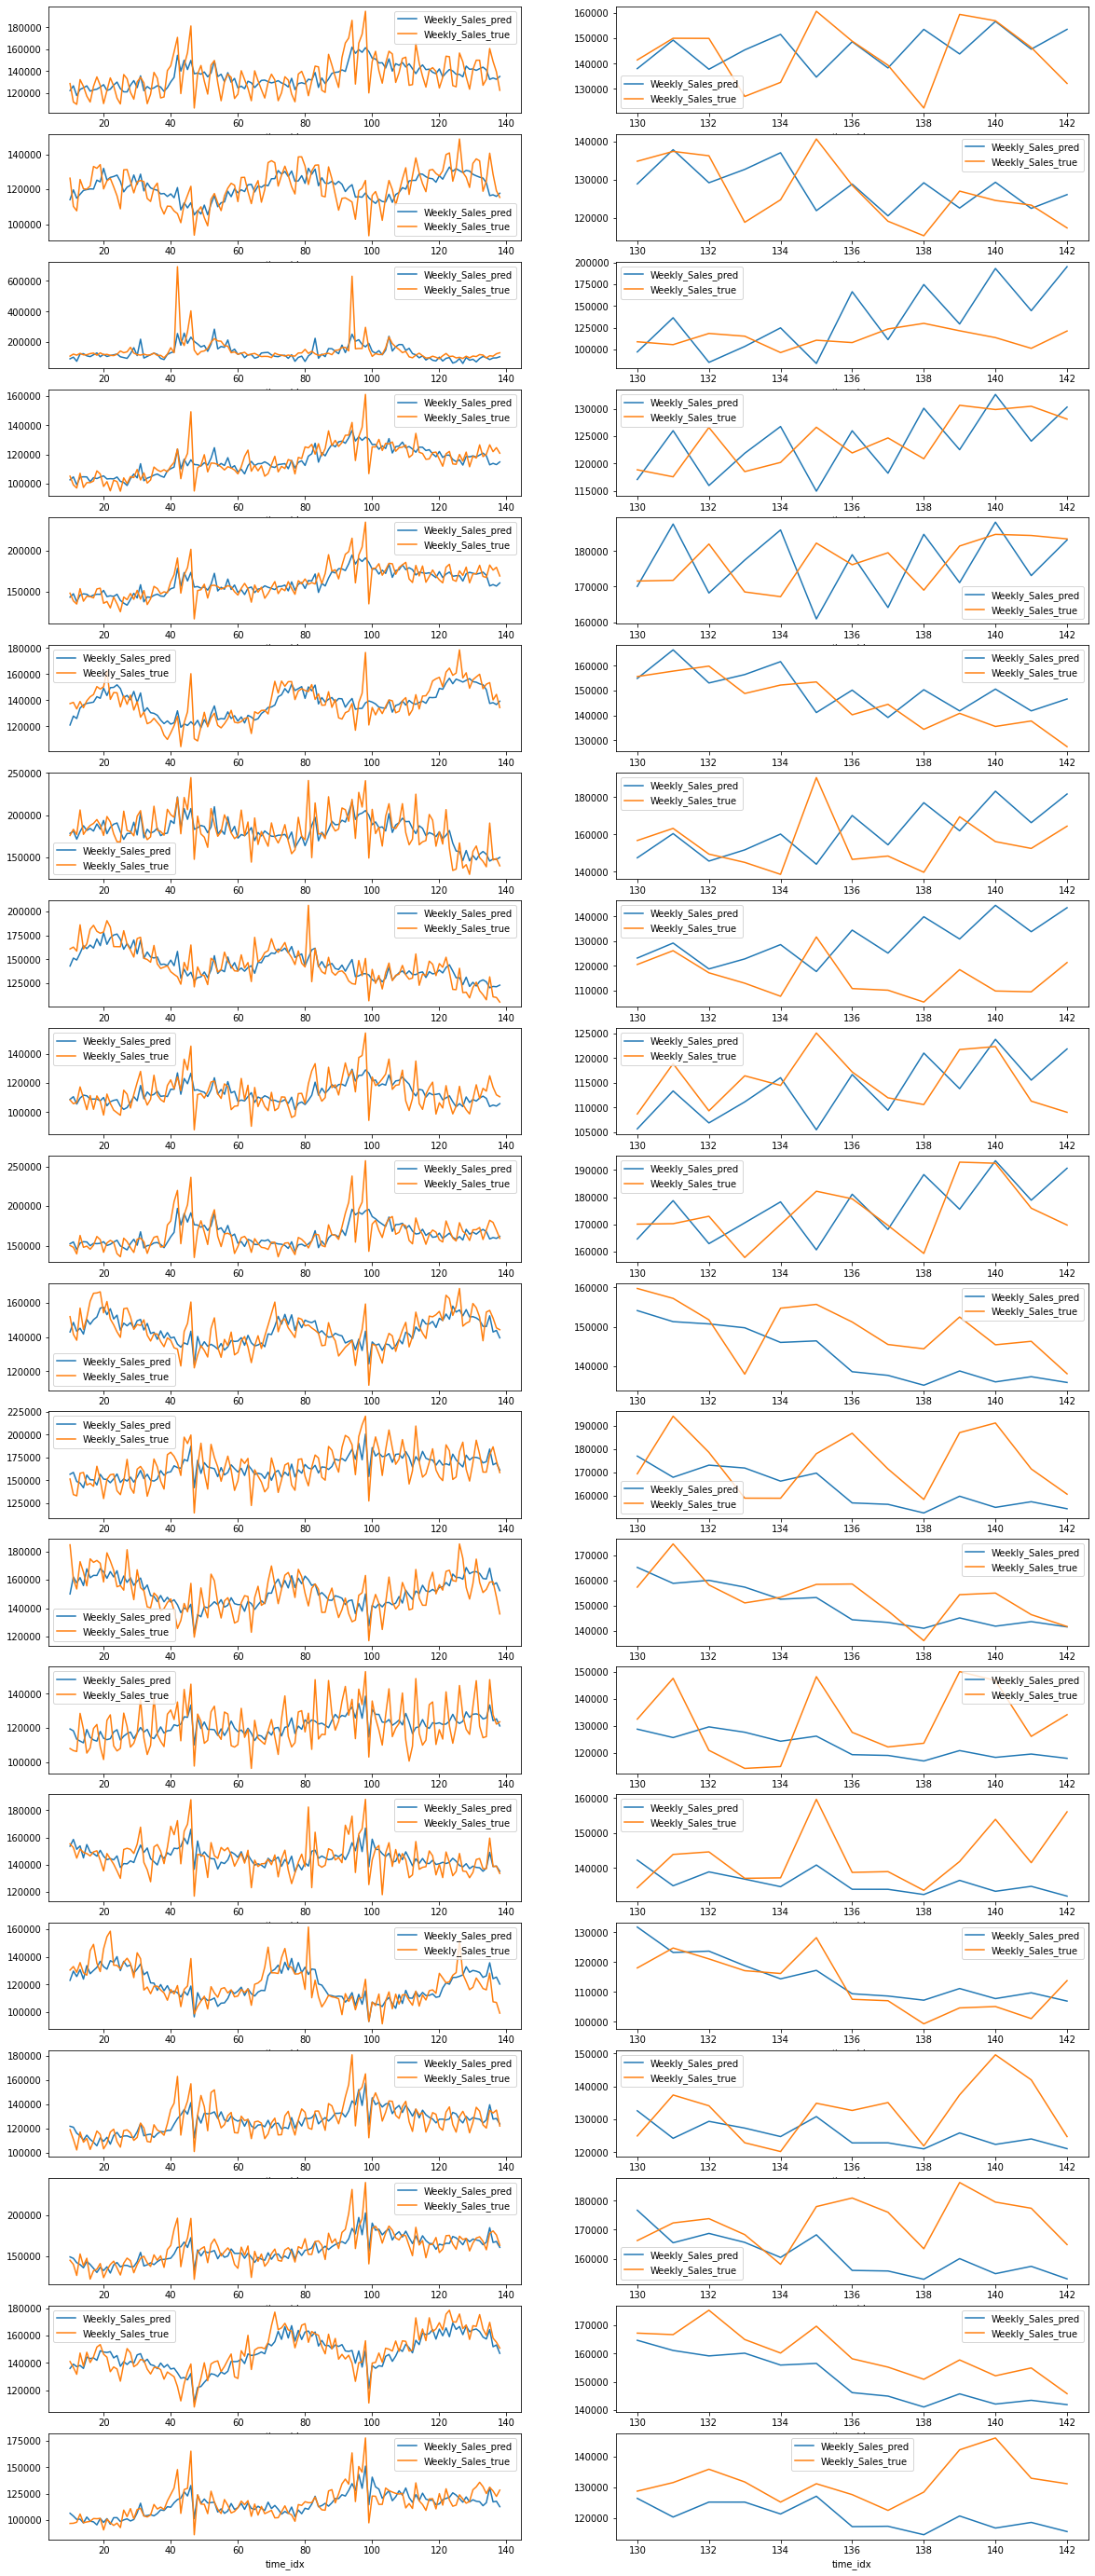

In [52]:
n = 20
groupby_train = yhat_train.groupby(group_ids)
groupby_test = yhat_test.groupby(group_ids)
fig, axs = plt.subplots(n, 2, figsize=(20, 50))
axs = axs.flatten()
i = 0
for i, g in enumerate(groupby_train.groups):
    if i >= n :
        break
    ax_l = axs[2 * i]
    ax_r = axs[2 * i + 1]
    try:
        groupby_train.get_group(g).set_index('time_idx').plot(ax=ax_l)
        groupby_test.get_group(g).set_index('time_idx').plot(ax=ax_r)
    except KeyError:
        continue
    
    i += 1
    

## Temporal fusion transformer (tft)

In [44]:
from mooncake.nn import TemporalFusionTransformer as TFT

In [48]:
# Fit

column_segmentation = {
    'static_categoricals': group_ids,
    'time_varying_unknown_reals': ['Weekly_Sales'],
    'time_varying_known_reals': ['x0_True', 'day_sine', 'day_cos', 'month_sine', 'month_cos']
}
lr_scheduler = {
        'policy': OneCycleLR,
        'step_every': 'batch',
        'max_lr': 1e-3,
        'steps_per_epoch': 'iterations',
        'epochs': 'max_epochs'
    }
callbacks = common_callbacks(
    lr_scheduler, 
    gradient_clipping=True,
    early_stopping=True, 
    patience=20
)

estimator = TFT(
    group_ids=group_ids,
    time_idx='time_idx',
    target=target,
    max_prediction_length=prediction_length,
    max_encoder_length=prediction_length,
    cv_split=X_test_transformed,
    batch_size=128,
    max_epochs=3,
    callbacks=callbacks,
    hidden_size=64,
    output_size=1,
    **column_segmentation
)

In [49]:
estimator.fit(X_train_transformed)

/Users/ramonamezquita/Projects/mooncake/mooncake-venv/lib/python3.9/site-packages/pytorch_forecasting/data/timeseries.py:1238: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 248 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': '1', '__group_id__Dept': '77'}, {'__group_id__Store': '1', '__group_id__Dept': '78'}, {'__group_id__Store': '10', '__group_id__Dept': '51'}, {'__group_id__Store': '10', '__group_id__Dept': '77'}, {'__group_id__Store': '10', '__group_id__Dept': '78'}, {'__group_id__Store': '11', '__group_id__Dept': '48'}, {'__group_id__Store': '11', '__group_id__Dept': '50'}, {'__group_id__Store': '11', '__group_id__Dept': '77'}, {'__group_id__Store': '11', '__group_id__Dept': '78'}, {'__group_id__Store': '12', '__group_id__Dept': '51'}]
  warnings.warn(
/Users/ramonamezquita/Projects/moonca

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.1857        0.1585  235.5410
      2        0.1488        0.1543  247.0046
      3        0.1406        0.1539  283.1342


TemporalFusionTransformer(batch_size=128,
                          callbacks=[('lr_scheduler',
                                      <skorch.callbacks.lr_scheduler.LRScheduler object at 0x28a93aee0>),
                                     ('early_stopping',
                                      <skorch.callbacks.training.EarlyStopping object at 0x28a93aeb0>),
                                     ('gradient_clipping',
                                      <skorch.callbacks.regularization.GradientNormClipping object at 0x28a93a3d0>)],
                          criterion=<class 'pytorch_forecasting.metr...
                          group_ids=['Store', 'Dept'], hidden_size=64,
                          max_encoder_length=10, max_epochs=3,
                          max_prediction_length=10,
                          optimizer=<class 'torch.optim.adam.Adam'>,
                          output_size=1, static_categoricals=['Store', 'Dept'],
                          target='Weekly_Sales', time_

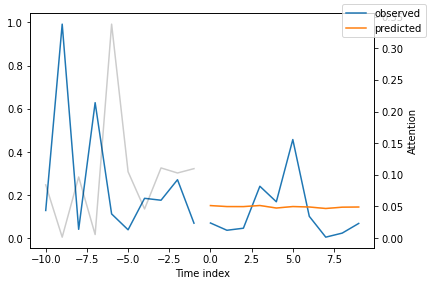

In [53]:
estimator.plot_prediction(X_train_transformed, idx=0)